In [52]:
using Revise

In [53]:
using PyCall, PyPlot, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [54]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [55]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))

@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.730200 seconds (99.87 k allocations: 4.053 MiB)


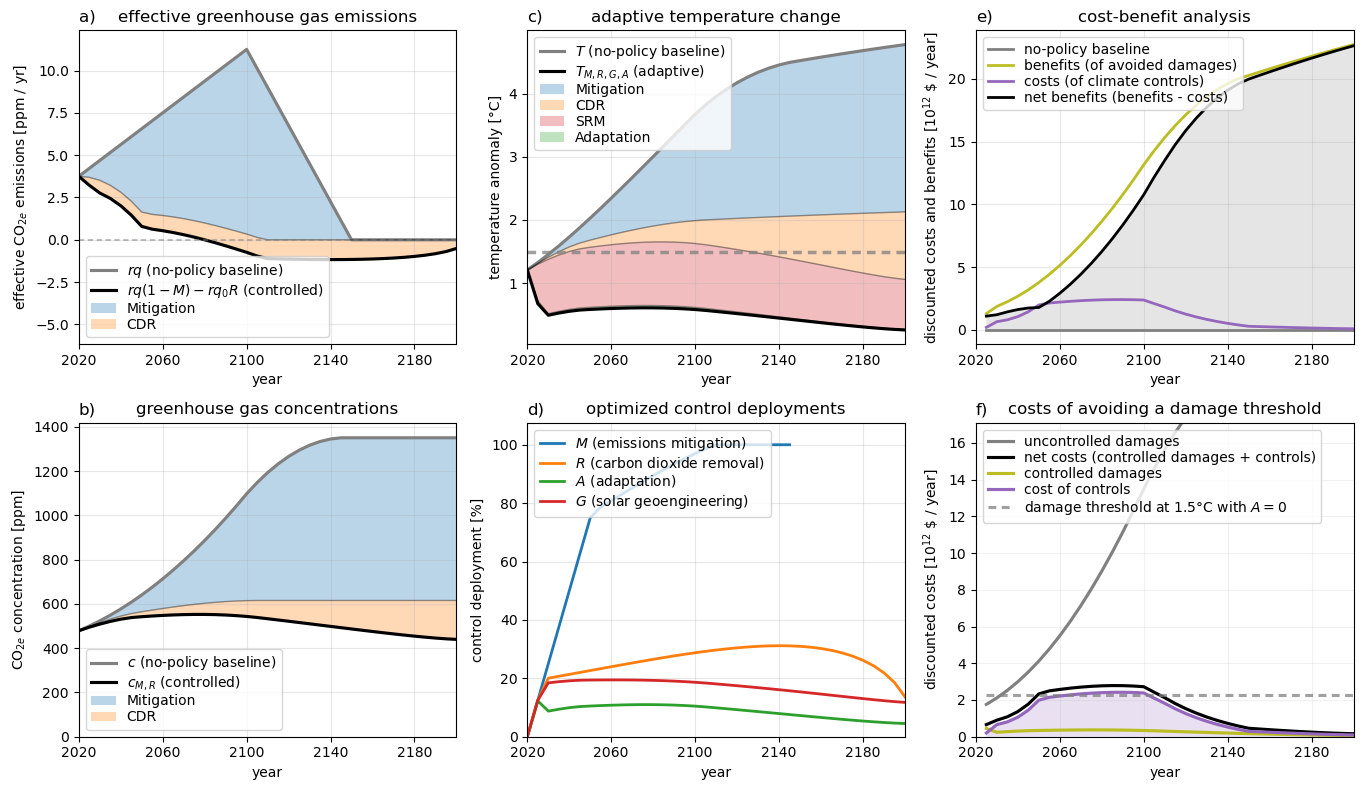

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <AxesSubplot:title={'left':'a)','center':'effective greenhouse gas emissions'}, xlabel='year', ylabel='effective CO$_{2e}$ emissions [ppm / yr]'>, PyObject <AxesSubplot:title={'left':'b)','center':'greenhouse gas concentrations'}, xlabel='year', ylabel='CO$_{2e}$ concentration [ppm]'>, PyObject <AxesSubplot:title={'left':'c)','center':'adaptive temperature change'}, xlabel='year', ylabel='temperature anomaly [°C]'>, PyObject <AxesSubplot:title={'left':'d)','center':'optimized control deployments'}, xlabel='year', ylabel='control deployment [%]'>, PyObject <AxesSubplot:title={'left':'e)','center':'cost-benefit analysis'}, xlabel='year', ylabel='discounted costs and benefits [10$^{12}$ \\$ / year]'>, PyObject <AxesSubplot:title={'left':'f)','center':'costs of avoiding a damage threshold'}, xlabel='year', ylabel='discounted costs [10$^{12}$ \\$ / year]'>])

In [56]:
plot_state(model, temp_goal=1.5)

In [57]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxgeoeng" => [], "T2100noG" => [], "T2100" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.1

for ρ in ρs
    tmp_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
    tmp_model.economics.ρ = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    q = model.economics.baseline_emissions
    Midx = q .> 0.
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate[Midx]))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["T2100noG"], T_adapt(tmp_model, M=true, R=true)[tidx])
    append!(stat_dict["T2100"], T_adapt(tmp_model, M=true, R=true, G=true, A=true)[tidx])
    append!(stat_dict["maxCO2"], maximum(c(tmp_model, M=true, R=true)))
end

Solve_Succeeded
  0.164411 seconds (104.22 k allocations: 4.137 MiB)
Solve_Succeeded
  0.216421 seconds (108.68 k allocations: 4.231 MiB)
Solve_Succeeded
  0.193458 seconds (108.68 k allocations: 4.231 MiB)
Solve_Succeeded
  0.206697 seconds (108.68 k allocations: 4.231 MiB)
Solve_Succeeded
  0.120087 seconds (104.33 k allocations: 4.146 MiB)
Solve_Succeeded
  0.146106 seconds (108.68 k allocations: 4.231 MiB)
Solve_Succeeded
  0.187346 seconds (104.33 k allocations: 4.146 MiB)
Solve_Succeeded
  0.137783 seconds (99.98 k allocations: 4.062 MiB)
Solve_Succeeded
  0.125008 seconds (99.98 k allocations: 4.062 MiB)
Solve_Succeeded
  5.927258 seconds (99.99 k allocations: 4.062 MiB, 97.65% gc time)
Solve_Succeeded
  0.063033 seconds (95.52 k allocations: 3.968 MiB)
Solve_Succeeded
  0.052716 seconds (95.63 k allocations: 3.978 MiB)
Solve_Succeeded
  0.054920 seconds (91.17 k allocations: 3.884 MiB)
Solve_Succeeded
  0.050874 seconds (91.28 k allocations: 3.893 MiB)
Solve_Succeeded
  0.05010

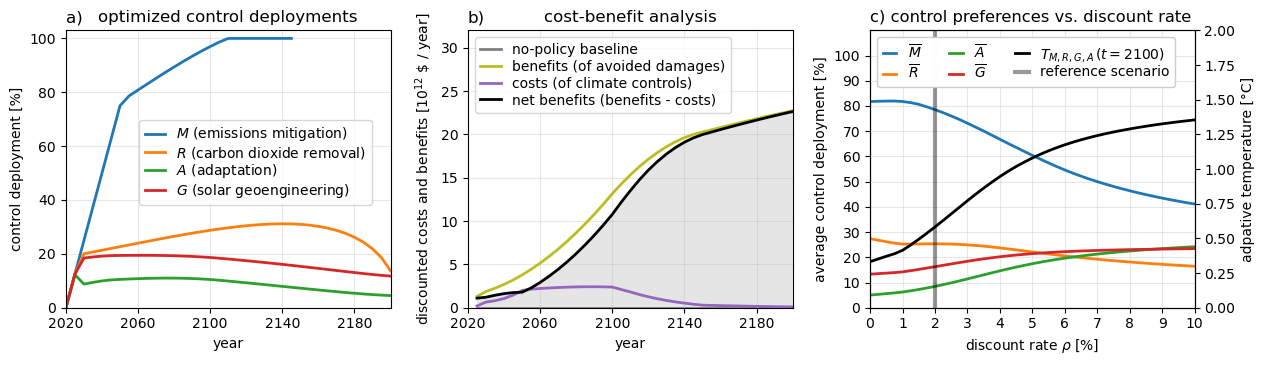

Maximum warming: 1.2083551842122768

In [58]:
fig = figure(figsize=(12.75,3.75))

ax = fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc=(0.225, 0.37), labelspacing=0.1)
title("a)", loc="left")
ylim(0, 1.03)

ax = fig.add_subplot(1,3,2)
plot_benefits(model, discounting=true)
legend(handlelength=1.5, loc="upper left", labelspacing=0.2)
title("b)", loc="left")
ylim([0., 32.])

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], lw=2, label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], lw=2, label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], lw=2, label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], lw=2, label=L"$\overline{G}$")
plot([], [], "k-", lw=2, label=L"$T_{M,R,G,A}\,(t=2100)$")
#plot(ρs, 1 .-(stat_dict["mitigate"]+stat_dict["remove"]+ stat_dict["adapt"]+stat_dict["geoeng"]), "k-", lw=2, label=L"$\max(T_{M,R,G,A})$")

axt = ax.twinx()  # instantiate a second axes that shares the same x-axis
axt.set_ylabel("adpative temperature [°C]")  # we already handled the x-label with ax1
axt.tick_params(axis="y")
axt.plot(ρs, stat_dict["T2100"], "k-", lw=2, label=L"$T_{M,R,G,A}\,(t=2100)$")
axt.set_ylim(0., 2)
axt.set_xlim([0., 0.1])
axt.set_xticks(0:0.01:0.1, 0:1:10)

sca(ax)
axvline(model.economics.ρ, color="k", label="reference scenario", alpha=0.4, lw=3)
legend(ncol=3, handlelength=1., labelspacing=0.14, loc="upper left", framealpha=0.99)
ylim([0, 1.1])
xlim([0., 0.1])
xticks(0:0.01:0.1, 0:1:10)
yticks(0:0.1:1, 0:10:100)
grid(true, alpha=0.3)
ylabel("average control deployment [%]")
title("c) control preferences vs. discount rate", loc="left", fontsize=11.75)
xlabel(L"discount rate $\rho$ [%]")

tight_layout()
savefig("figures/cost-benefit-analysis.png", dpi=200, bbox_inches="tight")

print("Maximum warming: ", maximum(T_adapt(model, M=true, R=true, G=true, A=true)))

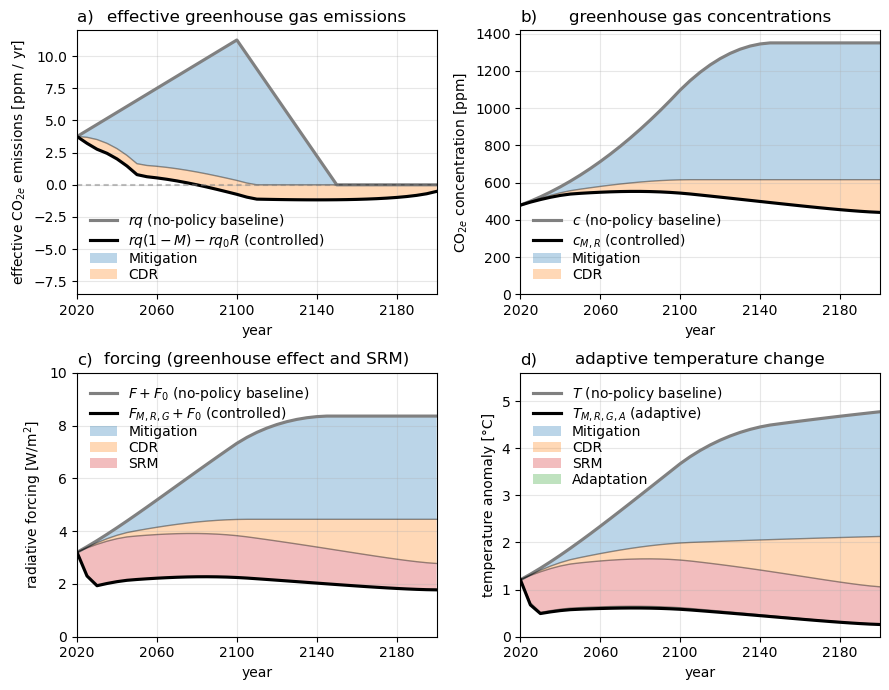

In [68]:
figure(figsize=(9,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("b)", loc="left")
ax = subplot(2,2,3)
plot_forcings(model)
handles, labels = ax.get_legend_handles_labels()
labels[1] = L"$F+F_{0}$ (no-policy baseline)"
labels[2] = L"$F_{M,R,G} + F_{0}$ (controlled)"
legend(handles=handles, labels=labels, loc="upper left", labelspacing=0.13, framealpha=0., fontsize=10)
title("c)", loc="left")
ylim(0, 10)
tight_layout()
subplot(2,2,4)
plot_temperatures(model, temp_goal=-1.)
legend(loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("d)", loc="left")
ylim(0, 5.6)
tight_layout()
savefig("figures/cost-benefit-outcomes.png", dpi=200, bbox_inches="tight")

In [44]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
model.economics.ρ = 0.075
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.050050 seconds (91.17 k allocations: 3.884 MiB)


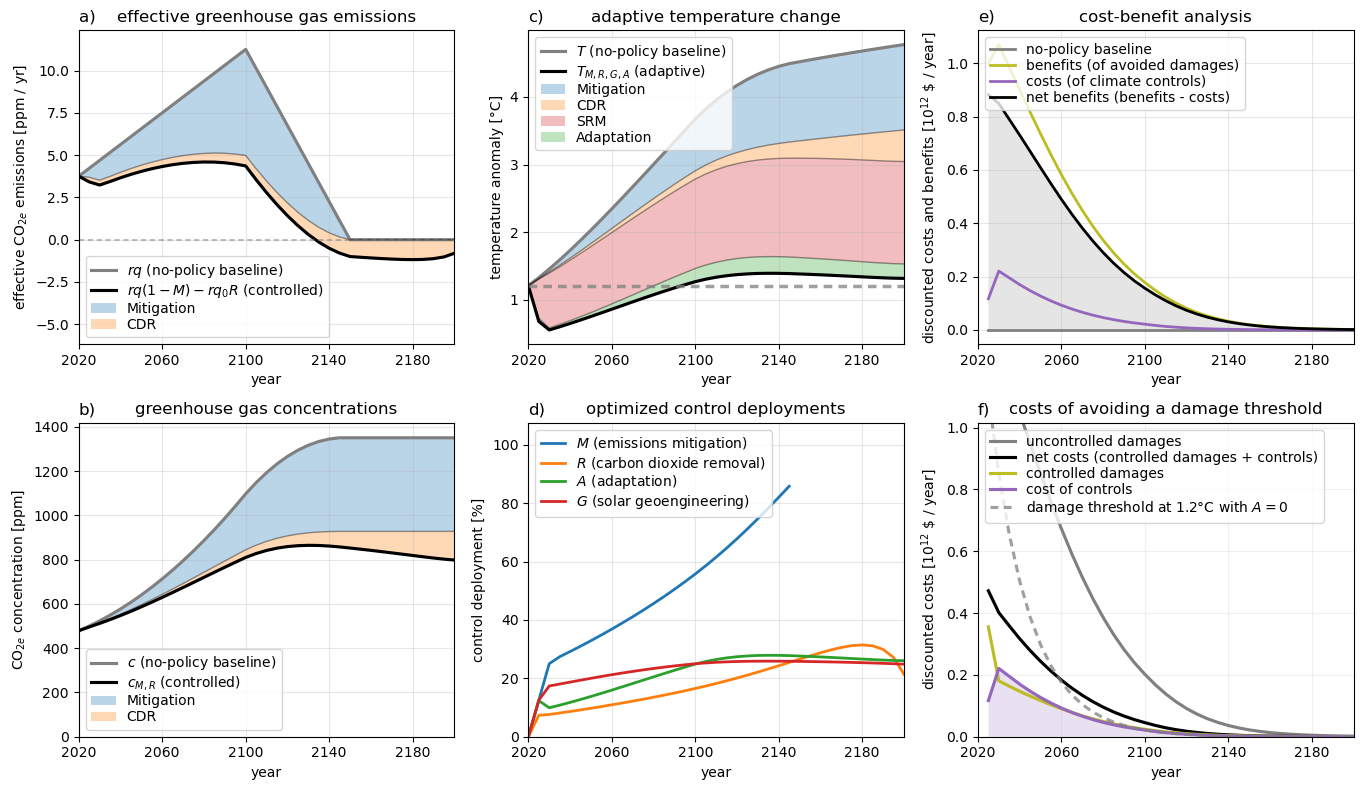

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <AxesSubplot:title={'left':'a)','center':'effective greenhouse gas emissions'}, xlabel='year', ylabel='effective CO$_{2e}$ emissions [ppm / yr]'>, PyObject <AxesSubplot:title={'left':'b)','center':'greenhouse gas concentrations'}, xlabel='year', ylabel='CO$_{2e}$ concentration [ppm]'>, PyObject <AxesSubplot:title={'left':'c)','center':'adaptive temperature change'}, xlabel='year', ylabel='temperature anomaly [°C]'>, PyObject <AxesSubplot:title={'left':'d)','center':'optimized control deployments'}, xlabel='year', ylabel='control deployment [%]'>, PyObject <AxesSubplot:title={'left':'e)','center':'cost-benefit analysis'}, xlabel='year', ylabel='discounted costs and benefits [10$^{12}$ \\$ / year]'>, PyObject <AxesSubplot:title={'left':'f)','center':'costs of avoiding a damage threshold'}, xlabel='year', ylabel='discounted costs [10$^{12}$ \\$ / year]'>])

In [45]:
plot_state(model)

#### Approach 2: Avoiding damage thresholds

In [69]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
max_deployment=Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>0.)
@time optimize_controls!(model, max_deployment=max_deployment);

Solve_Succeeded
  0.078478 seconds (110.17 k allocations: 4.492 MiB)


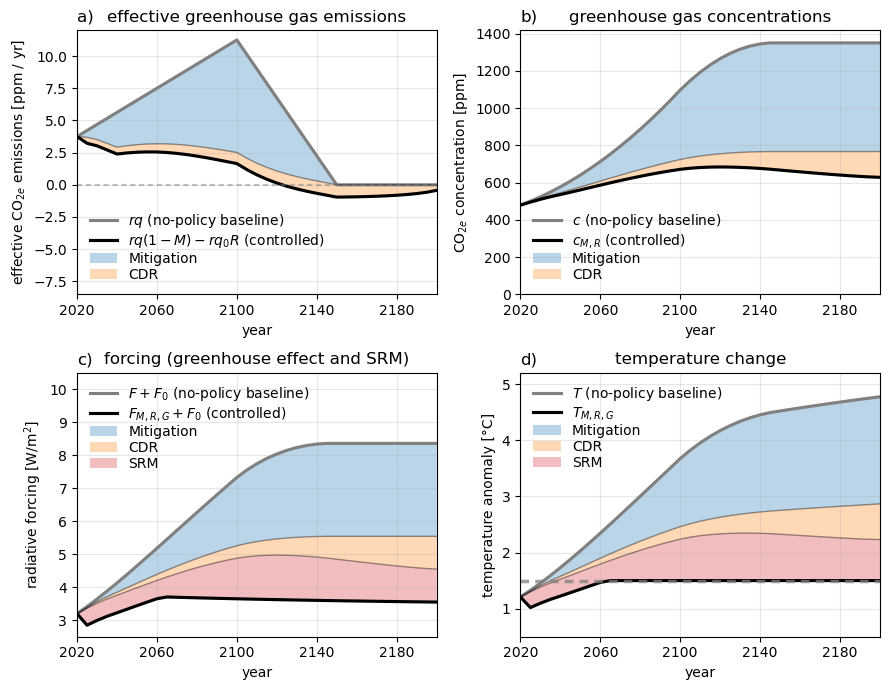

In [72]:
figure(figsize=(9,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14, framealpha=0., fontsize=10)
title("b)", loc="left")
ax = subplot(2,2,3)
plot_forcings(model)
handles, labels = ax.get_legend_handles_labels()
labels[1] = L"$F+F_{0}$ (no-policy baseline)"
labels[2] = L"$F_{M,R,G} + F_{0}$ (controlled)"
legend(handles=handles, labels=labels, loc="upper left", labelspacing=0.13, framealpha=0., fontsize=10)
title("c)", loc="left")
ylim(2.5, 10.5)
tight_layout()
ax = subplot(2,2,4)
plot_temperatures(model, temp_goal=1.5)
title("temperature change")
handles, labels = ax.get_legend_handles_labels()
labels[2] = L"$T_{M,R,G}$"

legend(handles=handles[1:end-1], labels=labels[1:end-1], loc="upper left", labelspacing=0.14, framealpha=0., fontsize=10)
title("d)", loc="left")
ylim(0.5, 5.2)
tight_layout()
savefig("figures/cost-effectiveness-outcomes.png", dpi=200, bbox_inches="tight")

In [50]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

ρs = 0.:0.001:0.1
CGs = 0.:0.01:1.;
models = Array{ClimateModel}(undef, size(ρs,1), size(CGs,1));

for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        tmp = deepcopy(base_model)
        tmp.economics.ρ = ρ
        tmp.economics.geoeng_cost = CG
        optimize_controls!(tmp, max_deployment=max_deployment, print_raw_status=false)
        models[i, j] = tmp
    end
end

GFmax = Array{Float64}(undef, size(ρs,1), size(CGs,1));
percent_Gcool = Array{Float64}(undef, size(ρs,1), size(CGs,1));
for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        GFmax[i,j] = maximum(F(models[i,j], M=true, R=true) - F(models[i,j], M=true, R=true, G=true))
        TN = sum(T(models[i,j]) .- 1.1)
        TM = sum(T(models[i,j]) .- T(models[i,j], M=true)) / TN
        TR = sum(T(models[i,j], M=true) .- T(models[i,j], M=true, R=true)) / TN
        TG = sum(T(models[i,j], M=true, R=true) .- T(models[i,j], M=true, R=true, G=true)) / TN
        TA = sum(T(models[i,j], M=true, R=true, G=true) .- T_adapt(models[i,j], M=true, R=true, G=true, A=true)) / TN
        percent_Gcool[i,j] = deepcopy(TG)
    end
end

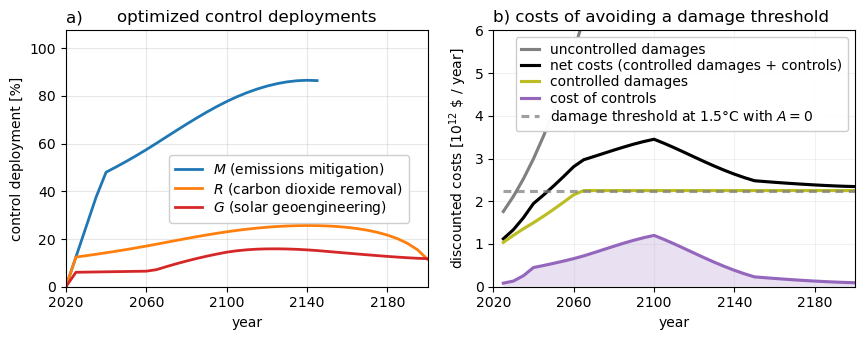

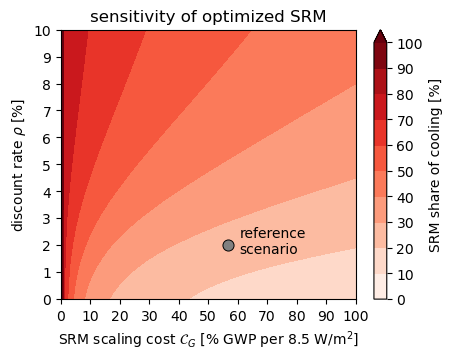

Net Present Control Costs = 94.46913201399869 trillion USD

In [51]:
figure(figsize=(8.75,3.5))

ax = subplot(1,2,1)
plot_controls(model)
lines = ax.get_lines()
lines[3].remove()
legend(loc=(0.285, 0.25), labelspacing=0.16, framealpha=0.95)
title("a)", loc="left")

subplot(1,2,2)
plot_damages(model, temp_goal=1.5)
legend(loc="upper right", labelspacing=0.16, framealpha=0.97, handlelength=1.3)
title("")
title("b) costs of avoiding a damage threshold", loc="left")
ylim([0, 6.0])

tight_layout(w_pad=0.025)
savefig("figures/cost-effectiveness-analysis.png", dpi=200, bbox_inches="tight")

print("Net Present Control Costs = ", net_present_cost(model, M=true, R=true, G=true, A=true), " trillion USD")

figure(figsize=(4.75,3.5))
percent_lev = 0:10:100
contourf(CGs, ρs, percent_Gcool*100, cmap="Reds", levels=percent_lev, extend="max")
colorbar(label = "SRM share of cooling [%]", ticks=percent_lev)
plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], color="grey", "o", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
annotate("reference\nscenario", (base_model.economics.geoeng_cost + 0.04, base_model.economics.ρ - 0.003))
yticks(0.:0.01:0.1, 0:1:10)
xticks(0.:0.1:1.0, 0:10:100)
xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP per 8.5 W/m$^{2}$]")
ylabel(L"discount rate $\rho$ [%]")
title("sensitivity of optimized SRM")
savefig("figures/cost-effectiveness-analysis-sensitivity.png", dpi=200, bbox_inches="tight")

# subplot(1,3,3)
# GFlev = 0.:0.5:4
# contourf(CGs, ρs, GFmax, cmap="Greys", levels=GFlev, extend="max")
# colorbar(label = L"maximum SRM cooling [W/m$^{2}$]", ticks=GFlev)
# plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], "ro", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
# annotate("reference\nscenario", (base_model.economics.geoeng_cost + 0.008, base_model.economics.ρ - 0.0021))
# yticks(0.:0.01:0.05, 0:1:5)
# xticks(0.:0.02:0.2, 0:2:20)
# xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP]")
# ylabel(L"discount rate $\rho$ [%]")
# title("sensitivity of optimal SRM")
# title("c)", loc="left")

4-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9ba59ed7c0>
 PyObject <matplotlib.lines.Line2D object at 0x7f9ba59ed790>
 PyObject <matplotlib.lines.Line2D object at 0x7f9ba5a54e80>
 PyObject <matplotlib.lines.Line2D object at 0x7f9ba59faeb0>